## BUGS

## TODO
- work on MixtureParamsMLP to output the right dimensions 
- how to print out trace for pi

## Resources
- [Tutorial on to_event and .expand()](https://bochang.me/blog/posts/pytorch-distributions/)
- [Event, Batch, Sample shapes](https://ericmjl.github.io/blog/2019/5/29/reasoning-about-shapes-and-probability-distributions/)
- [Debugging Neural Networks](https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn)

In [1]:
import numpy as np
import time

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam, AdamW
from pyro.nn import PyroModule

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

from tabulate import tabulate

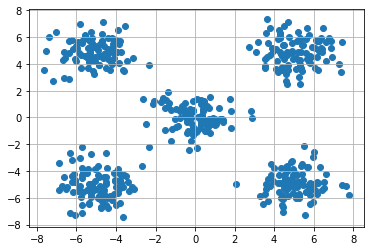

In [2]:
N = 500  # number of data points
M = 2  # number of features
T = 5  # Fixed number of components.

cov = np.identity(M)  # covariance matrix is just the identity for now

# generate data
clust1 = np.random.multivariate_normal(np.zeros(M), cov, 100)
clust2 = np.random.multivariate_normal(np.ones(M)*5, cov, 100)
clust3 = np.random.multivariate_normal(np.ones(M)*-5, cov, 100)
clust4 = np.random.multivariate_normal([5, -5], cov, 100)
clust5 = np.random.multivariate_normal([-5, 5], cov, 100)
data = np.concatenate((clust1, clust2, clust3, clust4, clust5))

plt.scatter(data[:,0], data[:,1])
plt.grid()

data = torch.from_numpy(data).float()  # convert numpy to torch

In [3]:
class MixtureMLP(PyroModule):
  '''
    PointNet inspired nn architecture for permutation invariance
    GitHub repo: https://github.com/fxia22/pointnet.pytorch/blob/f0c2430b0b1529e3f76fb5d6cd6ca14be763d975/pointnet/model.py#L11
    Paper: https://arxiv.org/pdf/1612.00593.pdf
  '''
  def __init__(self, output_size, M, softmax=True):
    super().__init__()
    
    self.output_size = output_size
    self.M = M
    self.softmax = softmax
    
    self.t_net = nn.Sequential(
        nn.Conv1d(self.M, 64, 1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        
        nn.Conv1d(64, 128, 1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        
        nn.Conv1d(128, 1024, 1),
        nn.BatchNorm1d(1024),
        nn.ReLU()
    )
    
    self.fully_connected = nn.Sequential(
        nn.Linear(1024, 512),
        # nn.BatchNorm1d(512),  # don't need batchnorm for only 1 batch
        nn.ReLU(),
        
        nn.Linear(512, 256),
        # nn.BatchNorm1d(256),
        nn.ReLU(),
        
        nn.Linear(256, self.output_size),
        nn.ReLU()
    )
    
    self.softmax = nn.Softmax(1)
    

  def forward(self, x):
    x = self.t_net(x[None,:,:])
    x = torch.max(x, 2, keepdim=True)[0]  # maxpooling layer
    # x = x.view(-1, 32)
    x = x.view(-1, 1024)
    x = self.fully_connected(x)
    
    if self.softmax:
        x = self.softmax(x)        
        
    return x.squeeze()  # remove any 1-d axes

In [4]:
def model(data, step):
    # global variables
    alpha = torch.ones(T)
    weights = pyro.sample('weights', Dirichlet(alpha))
    
    with pyro.plate('components', T):
        locs = pyro.sample('locs', MultivariateNormal(torch.zeros(M), torch.eye(M)))

    # local variables
    with pyro.plate('data', N):
        assignment = pyro.sample('assignments', Categorical(weights))
        pyro.sample('obs', MultivariateNormal(locs[assignment], torch.eye(M)), obs=data)
        
def guide(data, step):
    # amortize using MLP
    pyro.module('alpha_mlp', alpha_mlp)
    pyro.module('tau_mlp', tau_mlp)
    
    # sample mixture components mu
    tau = tau_mlp(data.permute(1,0).float())
    tau = tau.view(5,2)  # reshape tensor
    
    with pyro.plate('components', T):
        locs = pyro.sample('locs', MultivariateNormal(tau, torch.eye(M)))
    
    # sample cluster assignments
    alpha = alpha_mlp(data.permute(1,0).float()) # returns a vector of length T
    weights = pyro.sample('weights', Dirichlet(alpha))  # vector of length T
    with pyro.iarange('data', N):
        assignments = pyro.sample('assignments', Categorical(weights))
    
    if step % 1000 == 0:
        
        print('='*10, 'Iteration {}'.format(step), '='*10)
        weight_data = [weights[i] for i in range(len(weights))]
        weight_data.insert(0, 'props')

        mu1_data = [locs[i,0] for i in range(locs.shape[0])]
        mu1_data.insert(0, 'mu1')

        mu2_data = [locs[i,1] for i in range(locs.shape[0])]
        mu2_data.insert(0, 'mu2')
        
        data = [weight_data, mu1_data, mu2_data]
        
        print(tabulate(data, headers=['', 'clust1', 'clust2', 'clust3', 'clust4', 'clust5']))

In [ ]:
alpha_mlp = MixtureMLP(T, M).float()  # variational parameters for mixture proportions pi
tau_mlp = MixtureMLP(T*M, M).float() 

adam_params = {"lr": 0.0001}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 25000
start = time.time()
for step in range(n_steps):
    svi.step(data, step)
    pyro.get_param_store()
    if step % 1000 == 0:
        end = time.time()
        print('took', end-start, 'seconds')
        start = time.time()

========== Iteration 0 ==========
         clust1     clust2        clust3      clust4     clust5
-----  --------  ---------  ------------  ----------  ---------
props  0.261643   0.573112   1.69102e-10   0.0786639   0.086581
mu1    0.307878   0.134318  -0.248436     -0.261571   -1.36683
mu2    0.020843  -0.739396   0.65958       0.447766   -1.68435
took 0.1464214324951172 seconds
========== Iteration 1000 ==========
          clust1    clust2      clust3       clust4        clust5
-----  ---------  --------  ----------  -----------  ------------
props   0.373708  0.620104  0.00543401  0.000749982   3.89037e-06
mu1    -0.414755  1.4432    1.24392     1.50077      -0.258895
mu2    -1.11555   0.959373  1.72766     1.53263       0.309459
took 112.26802277565002 seconds
========== Iteration 2000 ==========
             clust1        clust2     clust3     clust4        clust5
-----  ------------  ------------  ---------  ---------  ------------
props   0.000796926   1.17789e-05  0.0415591  